In [1]:
# --- Notebook Cell 1: Imports & Setup ---

import mne
from mne import io
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import Path

# Define the subjects and sessions you want to process
subjects = [
    # "sub-13",
    # "sub-08",
    "sub-06",
    # "sub-07",
    # "sub-11",
    "sub-02"
]

sessions = ["ses-EMS", "ses-Vibro", "ses-Visual"]

# Paths (adapt to your own folder structure)
# base_path = Path("./prediction_error_EEG/ds003846-2.0.2")
base_path = Path("./ds003846-2.0.2")

# Event ID mapping: integer codes for each condition
event_id = {"normal": 2, "conflict": 3}

# Define your epoching window (in seconds)
tmin, tmax = -0.3, 0.7

# We’ll collect all single-subject Evokeds in a dict of dicts.
# For each session, we hold a list of Evoked objects for "normal" and for "conflict".
group_evokeds = {sess: {"normal": [], "conflict": []} for sess in sessions}


In [2]:
# --- Single-subject processing loop ---

for subject in subjects:
    for session in sessions:
        print(f"Processing {subject}, {session}...")

        # 1) Load the subject's preprocessed raw file
        #    (Assuming you saved it after ICA, referencing, etc.)
        processed_raw_path = (
            Path("processed_eeg_data")
            / subject
            / f"{session}_cleaned_raw.fif"
        )
        raw = io.read_raw_fif(processed_raw_path, preload=True)

        # 2) Load the corresponding .tsv events file
        events_file = (
            base_path
            / subject
            / session
            / "eeg"
            / f"{subject}_{session}_task-PredictionError_events.tsv"
        )
        events_df = pd.read_csv(events_file, sep="\t")

        # 3) Convert from 'onset' in seconds to sample indices for this raw's sfreq
        events_list = []
        for _, row in events_df.iterrows():
            event_dict = dict(item.split(":") for item in row["value"].split(";"))
            if "box" in event_dict and event_dict["box"] == "touched":
                onset_in_sec = float(row["onset"])
                sample_index = int(round(onset_in_sec * raw.info["sfreq"]))

                # Identify if normal_or_conflict is "normal" or "conflict"
                cond_label = event_dict["normal_or_conflict"]
                this_event_id = event_id[cond_label]

                events_list.append([sample_index, 0, this_event_id])

        # Convert to NumPy array
        events_array = np.array(events_list, int)

        # 4) Create epochs from this subject’s processed raw
        epochs = mne.Epochs(
            raw,
            events_array,
            event_id=event_id,
            tmin=tmin,
            tmax=tmax,
            baseline=(None, 0),
            preload=True,
            event_repeated="drop"
        )

        # (Optional) Drop noisiest epochs or set your reject thresholds
        peak_to_peak = np.ptp(epochs.get_data(), axis=2).mean(axis=1)
        threshold = np.percentile(peak_to_peak, 80)
        noisy_epochs = peak_to_peak > threshold
        epochs.drop(indices=np.where(noisy_epochs)[0], reason="manual")


        #    low-pass 10 Hz here or at the epoch level
        epochs_filtered = epochs

        # 5) Pick only the FCz channel and store the filtered epochs
        epochs_filtered_normal = epochs_filtered["normal"].pick_channels(["FCz"])
        epochs_filtered_conflict = epochs_filtered["conflict"].pick_channels(["FCz"])

        # 6) Append the single-channel epochs to the group dict
        group_evokeds[session]["normal"].append(epochs_filtered_normal)
        group_evokeds[session]["conflict"].append(epochs_filtered_conflict)



Processing sub-06, ses-EMS...
Opening raw data file processed_eeg_data/sub-06/ses-EMS_cleaned_raw.fif...
    Range : 0 ... 173681 =      0.000 ...   694.724 secs
Ready.
Reading 0 ... 173681  =      0.000 ...   694.724 secs...
Not setting metadata
206 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 206 events and 251 original time points ...
0 bad epochs dropped
Dropped 41 epochs: 0, 1, 2, 3, 6, 7, 8, 9, 14, 15, 17, 22, 23, 24, 25, 30, 31, 34, 35, 38, 39, 60, 61, 88, 89, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 122, 123, 132, 133, 144, 145
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Processing sub-06, ses-Vibro...
Opening raw data file processed_eeg_data/sub-06/ses-Vibro_cleaned_raw.fif...
    Range : 0 ... 466491 =      0.000 ...  1865.964 sec

Not setting metadata
243 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
420 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
355 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_31413/2571348829.py:13: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_normal = all_normal_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)
/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_31413/2571348829.py:14: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_conflict = all_conflict_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)
/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_31413/2571348829.py:13: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_normal = all_normal_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)
/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipyke

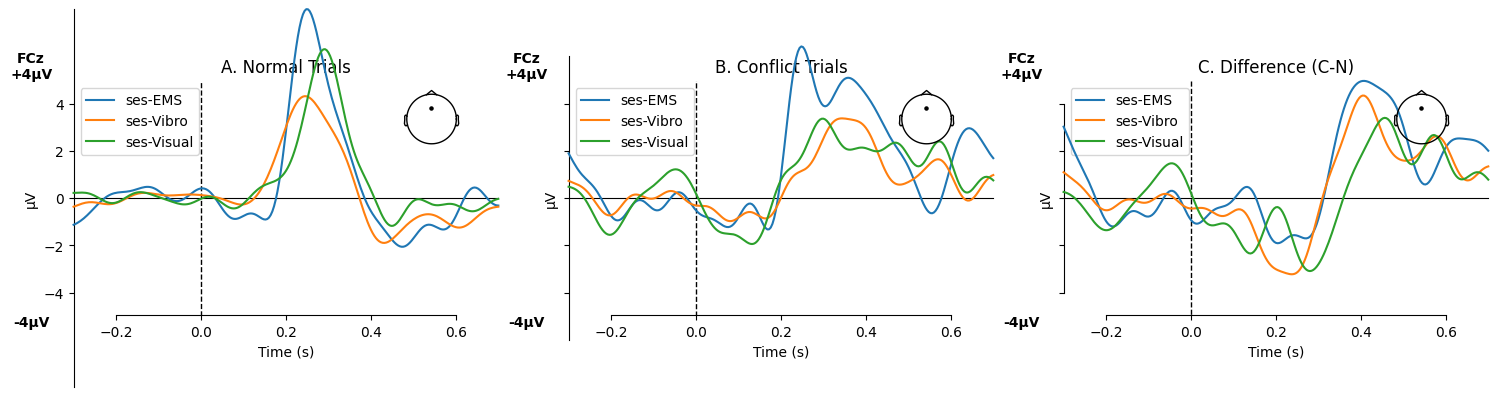

Session: ses-EMS
  Condition: normal, Number of Events Averaged (nave): 243
  Condition: conflict, Number of Events Averaged (nave): 82
  Condition: difference, Number of Events Averaged (nave): 61.31076923076923
Session: ses-Vibro
  Condition: normal, Number of Events Averaged (nave): 420
  Condition: conflict, Number of Events Averaged (nave): 137
  Condition: difference, Number of Events Averaged (nave): 103.30341113105925
Session: ses-Visual
  Condition: normal, Number of Events Averaged (nave): 355
  Condition: conflict, Number of Events Averaged (nave): 125
  Condition: difference, Number of Events Averaged (nave): 92.44791666666667


In [ ]:
from mne.viz import plot_compare_evokeds
import matplotlib.pyplot as plt

# Ensure grand_averages is already computed
grand_averages = {}

for session in sessions:
    # Concatenate epochs across subjects for the current session
    all_normal_epochs = mne.concatenate_epochs(group_evokeds[session]["normal"])
    all_conflict_epochs = mne.concatenate_epochs(group_evokeds[session]["conflict"])

    # Compute the Evoked (average) for each condition
    evoked_normal = all_normal_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)
    evoked_conflict = all_conflict_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)

    # Compute the difference (Conflict - Normal)
    evoked_difference = mne.combine_evoked([evoked_conflict, evoked_normal], weights=[1, -1])

    # Store the grand averages
    grand_averages[session] = {
        "normal": evoked_normal,
        "conflict": evoked_conflict,
        "difference": evoked_difference
    }

# Create dictionaries for plot_compare_evokeds
evokeds_normal = {session: grand_averages[session]["normal"] for session in sessions}
evokeds_conflict = {session: grand_averages[session]["conflict"] for session in sessions}
evokeds_difference = {session: grand_averages[session]["difference"] for session in sessions}

# Plotting the grand averages
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Define the channel name dynamically (e.g., "FCz")
channel_name = evokeds_normal[sessions[0]].info["ch_names"][0]  # Assuming the first channel is "FCz"

# Plot each condition dynamically
plot_compare_evokeds(
    evokeds_normal,
    picks=channel_name,
    combine="mean",
    ci=True,  # Show confidence intervals
    axes=axes[0],
    title="A. Normal Trials",
    show=False
)

plot_compare_evokeds(
    evokeds_conflict,
    picks=channel_name,
    combine="mean",
    ci=True,  # Show confidence intervals
    axes=axes[1],
    title="B. Conflict Trials",
    show=False
)

plot_compare_evokeds(
    evokeds_difference,
    picks=channel_name,
    combine="mean",
    ci=True,  # Show confidence intervals
    axes=axes[2],
    title="C. Difference (C-N)",
    show=False
)

# Dynamically annotate plots
for ax in axes:
    # Add y-axis labels dynamically based on the data
    y_min, y_max = ax.get_ylim()  # Get the min and max y-axis values
    ax.text(
        ax.get_xlim()[0] - 0.1, y_max, f"{channel_name}\n+{int(y_max)}µV",
        fontsize=10, ha="center", va="bottom", weight="bold"
    )
    ax.text(
        ax.get_xlim()[0] - 0.1, y_min, f"-{int(abs(y_min))}µV",
        fontsize=10, ha="center", va="top", weight="bold"
    )

plt.tight_layout()
plt.show()


# Print the number of averaged events for each session and condition
for session, averages in grand_averages.items():
    print(f"Session: {session}")
    for condition, evoked in averages.items():
        print(f"  Condition: {condition}, Number of Events Averaged (nave): {evoked.nave}")



In [4]:
# # per subject plot
# from mne.viz import plot_compare_evokeds
# for i, subject in enumerate(subjects):
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

#     # Dictionaries to store Evoked objects for all sessions
#     evokeds_normal = {}
#     evokeds_conflict = {}
#     evokeds_difference = {}

#     for session in sessions:
#         # Retrieve the single-subject Evoked objects for this session
#         evoked_normal = group_evokeds[session]["normal"][i].average(picks="FCz")
#         evoked_conflict = group_evokeds[session]["conflict"][i].average(picks="FCz")
#         evoked_difference = mne.combine_evoked(
#             [evoked_conflict, evoked_normal], weights=[1, -1]
#         )

#         # Add them to the dictionaries with session keys
#         evokeds_normal[session] = evoked_normal
#         evokeds_conflict[session] = evoked_conflict
#         evokeds_difference[session] = evoked_difference

#     # --- Left subplot: Normal ---
#     plot_compare_evokeds(
#         evokeds_normal,  # Dictionary of Evoked objects for all sessions
#         picks="FCz",
#         combine="mean",  # No channel averaging, just pick FCz
#         ci=False,
#         axes=axes[0],
#         title=f"A. Normal Trials - {subject}",
#         show=False
#     )

#     # --- Middle subplot: Conflict ---
#     plot_compare_evokeds(
#         evokeds_conflict,  # Dictionary of Evoked objects for all sessions
#         picks="FCz",
#         combine="mean",
#         ci=False,
#         axes=axes[1],
#         title=f"B. Conflict Trials - {subject}",
#         show=False
#     )

#     # --- Right subplot: Difference (Conflict - Normal) ---
#     plot_compare_evokeds(
#         evokeds_difference,  # Dictionary of Evoked objects for all sessions
#         picks="FCz",
#         combine="mean",
#         ci=False,
#         axes=axes[2],
#         title=f"C. Difference (C - N) - {subject}",
#         show=False
#     )

#     # Finalize and show the plot for the current subject
#     plt.tight_layout()
#     plt.show()

